### 0. Initialisation

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import model_selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest


In [3]:
DATA_IN_FOLDER = 'C:/prairie/projet8-1/Immothep/data/cleaned/'

### 1. Exploratory Data Analysis

In [4]:
#Work with Homes, Sells
global_data = pd.read_csv(os.path.join(DATA_IN_FOLDER, 'Maison_valeursfoncieres.csv'), encoding='utf-8', sep=';', decimal='.')

global_data = global_data[global_data['Nature mutation'] == 'Vente']

# Check the number of data points in the data set
print(f'number of Homes sold : {len(global_data)}')
# Check the number of features in the data set
print(f'number of columns : {len(global_data.columns)}'   )
# Check the data types
print(f'data types : {global_data.dtypes.unique()}')

print('non numerical columns : ' + str(global_data.select_dtypes(include=['O']).columns.tolist()))
# Check any number of columns with NaN
print(f'number of columns with any NaN values : {global_data.isnull().any().sum()} / {len(global_data.columns)}')
# Check any number of data points with NaN
print(f'number of rows with any NaN values : {global_data.isnull().any(axis=1).sum()} / {len(global_data)}')


number of Homes sold : 504623
number of columns : 7
data types : [dtype('O') dtype('int64') dtype('float64')]
non numerical columns : ['Nature mutation']
number of columns with any NaN values : 0 / 7
number of rows with any NaN values : 0 / 504623


### Cleanup limits

In [5]:
curated_data = global_data.copy(deep=True)

count    504623.000000
mean        103.331182
std          46.641659
min           0.000000
25%          75.000000
50%          95.000000
75%         123.000000
max        1110.000000
Name: Surface reelle bati, dtype: float64


Text(0.5, 0.98, 'Surface batie')

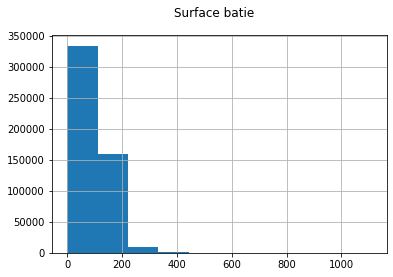

In [6]:
print(global_data['Surface reelle bati'].describe())
global_data['Surface reelle bati'].hist()
plt.suptitle('Surface batie')

Text(0.5, 0.98, 'Surface batie')

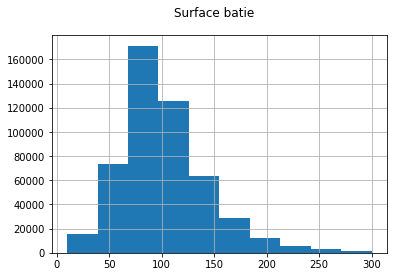

In [7]:
#drop surfaces between 20 and 300
curated_data.drop(curated_data[(curated_data['Surface reelle bati']<10 ) | (curated_data['Surface reelle bati']> 300 )].index, inplace=True)
curated_data['Surface reelle bati'].hist()
plt.suptitle('Surface batie')

count    504623.000000
mean          4.243568
std           1.518508
min           0.000000
25%           3.000000
50%           4.000000
75%           5.000000
max          67.000000
Name: Nombre pieces principales, dtype: float64


Text(0.5, 0.98, 'Number of room')

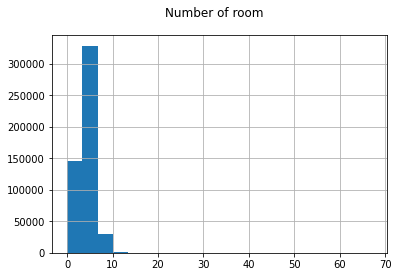

In [8]:
print(global_data['Nombre pieces principales'].describe())
global_data['Nombre pieces principales'].hist(bins=20)
plt.suptitle('Number of room')

Text(0.5, 0.98, 'Number of room')

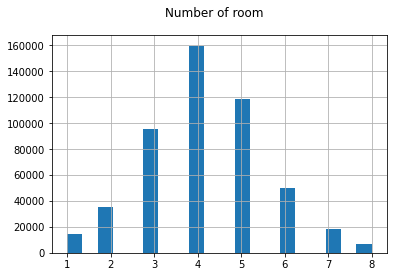

In [9]:
curated_data.drop(curated_data[(curated_data['Nombre pieces principales']> 8 )].index, inplace=True)
curated_data.loc[curated_data['Nombre pieces principales'] == 0] = 1
curated_data['Nombre pieces principales'].hist(bins=20)
plt.suptitle('Number of room')

count    504623.000000
mean        851.467030
std        3110.197223
min           0.000000
25%         256.000000
50%         500.000000
75%         832.000000
max      556633.000000
Name: Surface terrain, dtype: float64


Text(0.5, 0.98, 'Surface terrain')

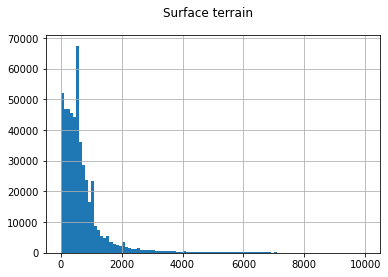

In [10]:
print(global_data['Surface terrain'].describe())
global_data['Surface terrain'].hist(bins=100, range=(0,10000))
plt.suptitle('Surface terrain')

Text(0.5, 0.98, 'Surface terrain')

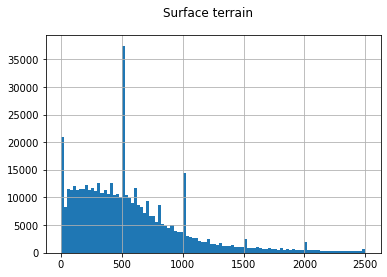

In [11]:
curated_data.drop(curated_data[(curated_data['Surface terrain']> 2500 )].index, inplace=True)
curated_data['Surface terrain'].hist(bins=100)
plt.suptitle('Surface terrain')

count    5.046230e+05
mean     3.148840e+05
std      5.758001e+06
min      1.500000e-01
25%      1.130000e+05
50%      1.789200e+05
75%      2.780000e+05
max      2.086000e+09
Name: Valeur fonciere, dtype: float64


Text(0.5, 0.98, 'Valeur fonciere')

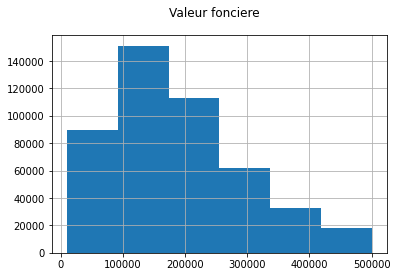

In [12]:
print(global_data['Valeur fonciere'].describe())
global_data['Valeur fonciere'].hist(bins=6, range=(10000,500000))
plt.suptitle('Valeur fonciere')

Text(0.5, 0.98, 'Valeur fonciere')

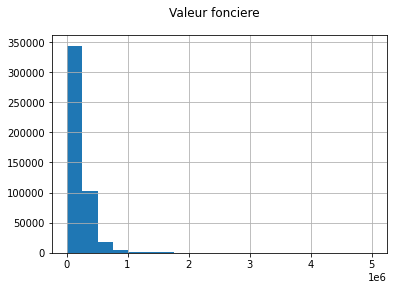

In [13]:
curated_data.drop(curated_data[(curated_data['Valeur fonciere']> 5000000 ) | (curated_data['Valeur fonciere'] < 10000)].index, inplace=True)
curated_data['Valeur fonciere'].hist(bins=20)
plt.suptitle('Valeur fonciere')


In [14]:
#Use Isolation forest model to finalize cleanup of dataset
df = curated_data[['Surface reelle bati','Nombre pieces principales','Surface terrain', 'Valeur fonciere']]

iForest = IsolationForest(n_estimators=100,  contamination=0.1 , random_state=42, max_samples=200)
iForest.fit(df)

df['anomaly'] = iForest.predict(df)
print('number of anomalies found : %s' % len(df[df['anomaly'] == -1]))

curated_data.drop(df.loc[df['anomaly'] == -1].index, inplace=True)

print('new number of data : %s' % len(curated_data))


number of anomalies found : 47444
new number of data : 426995


<AxesSubplot:>

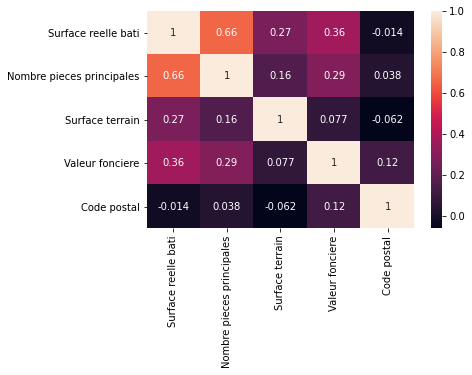

In [15]:

# New correlation matrix
matrix = curated_data[['Surface reelle bati','Nombre pieces principales','Surface terrain','Valeur fonciere','Code postal' ]]
mat_corr = matrix.corr().round(5)
sns.heatmap(data=mat_corr, annot=True)



### 2. Correlations between features and target

In [16]:

features = curated_data.iloc[:,3:].columns.tolist()
target = curated_data.iloc[:,2].name

correlations = {}
for f in features:
    data_temp = curated_data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]


In [17]:

data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]


,Value
Surface reelle bati vs Valeur fonciere,0.362801
Nombre pieces principales vs Valeur fonciere,0.286720
Code postal vs Valeur fonciere,0.121163
Surface terrain vs Valeur fonciere,0.076936


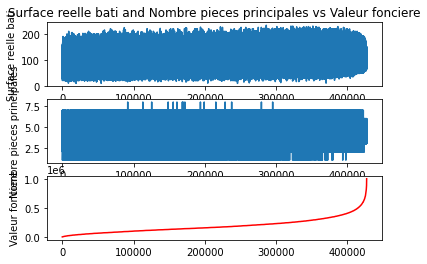

In [18]:

y = curated_data.loc[:,['Surface reelle bati','Nombre pieces principales', target]].sort_values(target, ascending=True).values
x = np.arange(y.shape[0])

plt.subplot(3,1,1)
plt.plot(x,y[:,0])
plt.title('Surface reelle bati and Nombre pieces principales vs Valeur fonciere')
plt.ylabel('Surface reelle bati')

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('Nombre pieces principales')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],'r')
plt.ylabel('Valeur fonciere')


plt.show()




In [19]:
#check best department to run the model (most sells)
tmp_data = curated_data.copy()
tmp_data['Department'] = curated_data['Code postal'].map(lambda x: int(x/1000))
print(tmp_data.groupby(['Department'])['Department'].count().sort_values(ascending=False))
del(tmp_data)


Department
59    22833
33    17487
44    16064
77    13668
85    11998
      ...  
90      483
15      468
20      259
84      149
75        5
Name: Department, Length: 93, dtype: int64


In [20]:
#specify departement to apply linear regression
department = 90
working_data = curated_data[(curated_data['Code postal'] >= department*1000) & (curated_data['Code postal'] < (department+1) * 1000)  ]
print('Working dataset : %s' % len(working_data))

Working dataset : 483


In [21]:
regr = LinearRegression()

X =  working_data[['Surface reelle bati','Nombre pieces principales','Surface terrain']].values
y = working_data['Valeur fonciere'].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y ,test_size=0.3)


In [22]:
regr.fit(X_train, y_train)
score = regr.score(X_test,y_test)
print("Training score xith skLearn: ", score)


Training score xith skLearn:  0.3166286347825989


In [23]:
scores = cross_val_score(regr, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.31


In [24]:
# Calculate the Root Mean Squared Error
print("RMSE: L'erreur quadratique moyenne est de %.2f€"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))


RMSE: L'erreur quadratique moyenne est de 66443.60€


In [25]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,                    colsample_bytree=1, max_depth=7)

xgb.fit(X_train,y_train)

score = xgb.score(X_train, y_train)  
print("Training score xith Xgboost: ", score)


Training score xith Xgboost:  0.9425996264478308


In [26]:
scores = cross_val_score(xgb, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())


Mean cross-validation score: 0.14


In [27]:
# Calculate the Root Mean Squared Error
print("RMSE: L'erreur quadratique moyenne est de %.2f€"
      % math.sqrt(np.mean((xgb.predict(X_test) - y_test) ** 2)))

RMSE: L'erreur quadratique moyenne est de 65038.41€


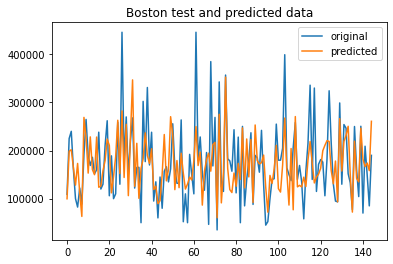

In [28]:
ypred = xgb.predict(X_test)
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")

plt.title("Boston test and predicted data")

plt.legend()
plt.show()